In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot 
from sklearn.neighbors import NearestNeighbors

In [2]:
def construct_graph_torch(X, k, mode='connectivity', metric = 'minkowski', p=2, device='cuda'):
    '''construct knn graph with torch and gpu
    args:
        X: input data containing features (torch tensor)
        k: number of neighbors for each data point
        mode: 'connectivity' or 'distance'
        metric: distance metric (now euclidean supported for gpu knn)
        p: param for minkowski (not used if metric is euclidean)
    
    Returns:
        knn graph as a pytorch sparse tensor (coo format) or dense tensor depending on mode     
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'."
    assert metric == 'euclidean', "for gpu knn, only 'euclidean' metric is currently supported in this implementation"

    if mode == 'connectivity':
        include_self = True
        mode_knn = 'connectivity'
    else:
        include_self = False
        mode_knn = 'distance'

    n_samples = X.shape[0]
    knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')

    if device == 'cuda' and torch.cuda.is_available():
        X_cpu = X.cpu().numpy()
    else:
        X_cpu = X.numpy()

    knn.fit(X_cpu)
    knn_graph_cpu = kneighbors_graph(knn, k, mode=mode_knn, include_self=include_self, metric=metric) #scipy sparse matrix on cpu
    knn_graph_coo = knn_graph_cpu.tocoo()

    if mode == 'connectivity':
        knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),
                                            torch.FloatTensor(knn_graph_coo.data),
                                            size = knn_graph_coo.shape).to(device)
    elif mode == 'distance':
        knn_graph_dense = torch.tensor(knn_graph_cpu.toarray(), dtype=torch.float32, device=device) #move to gpu as dense tensor
        knn_graph = knn_graph_dense
    
    return knn_graph
    
def distances_cal_torch(graph, type_aware=None, aware_power =2, device='cuda'):
    '''
    calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (pytorch sparse or dense tensor)
        type_aware: not implemented in this torch version for simplicity
        aware_power: same ^^
        device (str): 'cpu' or 'cuda' device to use
    Returns:
        distance matrix as a torch tensor
    '''

    if isinstance(graph, torch.Tensor) and graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().to_dense().numpy())
    elif isinstance(graph, torch.Tensor) and not graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().numpy())
    else:
        graph_cpu_csr = csr_matrix(graph) #assume scipy sparse matrix if not torch tensor

    shortestPath_cpu = dijkstra(csgraph = graph_cpu_csr, directed=False, return_predecessors=False) #dijkstra on cpu
    shortestPath = torch.tensor(shortestPath_cpu, dtype=torch.float32, device=device)

    # the_max = torch.nanmax(shortestPath[shortestPath != float('inf')])
    # shortestPath[shortestPath > the_max] = the_max

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = torch.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= torch.mean(C_dis)
    return C_dis

def calculate_D_sc_torch(X_sc, k_neighbors=10, graph_mode='connectivity', device='cpu'):
    '''calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (torch sparse or dense tensor)
        type_aware: not implemented
        aware_power: same ^^
        
    returns:
        distanced matrix as torch tensor'''
    
    if not isinstance(X_sc, torch.Tensor):
        raise TypeError('Input X_sc must be a pytorch tensor')
    
    if device == 'cuda' and torch.cuda.is_available():
        X_sc = X_sc.cuda(device=device)
    else:
        X_sc = X_sc.cpu()
        device= 'cpu'

    print(f'using device: {device}')
    print(f'constructing knn graph...')
    # X_normalized = normalize(X_sc.cpu().numpy(), norm='l2') #normalize on cpu for sklearn knn
    X_normalized = X_sc
    X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)

    Xgraph = construct_graph_torch(X_normalized_torch, k=k_neighbors, mode=graph_mode, metric='euclidean', device=device)

    print('calculating distances from graph....')
    D_sc = distances_cal_torch(Xgraph, device=device)

    print('D_sc calculation complete')
    
    return D_sc


In [3]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot

def construct_graph_spatial(location_array, k, mode='distance', metric='euclidean', p=2):
    '''construct KNN graph based on spatial coordinates
    args:
        location_array: spatial coordinates of spots (n-spots * 2)
        k: number of neighbors for each spot
        mode: 'connectivity' or 'distance'
        metric: distance metric for knn (p=2 is euclidean)
        p: param for minkowski if connectivity
        
    returns:
        scipy.sparse.csr_matrix: knn graph in csr format
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'"
    if mode == 'connectivity':
        include_self = True
    else:
        include_self = False
    
    c_graph = kneighbors_graph(location_array, k, mode=mode, metric=metric, include_self=include_self, p=p)
    return c_graph

def distances_cal_spatial(graph, spot_ids=None, spot_types=None, aware_power=2):
    '''calculate spatial distance matrix from knn graph
    args:
        graph (scipy.sparse.csr_matrix): knn graph
        spot_ids (list, optional): list of spot ids corresponding to the rows/cols of the graph. required if type_aware is used
        spot_types (pd.Series, optinal): pandas series of spot types for type aware distance adjustment. required if type_aware is used
        aware_power (int): power for type-aware distance adjustment
        
    returns:
        sptial distance matrix'''
    shortestPath = dijkstra(csgraph = csr_matrix(graph), directed=False, return_predecessors=False)
    shortestPath = np.nan_to_num(shortestPath, nan=np.inf) #handle potential inf valyes after dijkstra

    if spot_types is not None and spot_ids is not None:
        shortestPath_df = pd.DataFrame(shortestPath, index=spot_ids, columns=spot_ids)
        shortestPath_df['id1'] = shortestPath_df.index
        shortestPath_melted = shortestPath_df.melt(id_vars=['id1'], var_name='id2', value_name='value')

        type_aware_df = pd.DataFrame({'spot': spot_ids, 'spot_type': spot_types}, index=spot_ids)
        meta1 = type_aware_df.copy()
        meta1.columns = ['id1', 'type1']
        meta2 = type_aware_df.copy()
        meta2.columns = ['id2', 'type2']

        shortestPath_melted = pd.merge(shortestPath_melted, meta1, on='id1', how='left')
        shortestPath_melted = pd.merge(shortestPath_melted, meta2, on='id2', how='left')

        shortestPath_melted['same_type'] = shortestPath_melted['type1'] == shortestPath_melted['type2']
        shortestPath_melted.loc[(~shortestPath_melted.smae_type), 'value'] = shortestPath_melted.loc[(~shortestPath_melted.same_type),
                                                                                                     'value'] * aware_power
        shortestPath_melted.drop(['type1', 'type2', 'same_type'], axis=1, inplace=True)
        shortestPath_pivot = shortestPath_melted.pivot(index='id1', columns='id2', values='value')

        order = spot_ids
        shortestPath = shortestPath_pivot[order].loc[order].values
    else:
        shortestPath = np.asarray(shortestPath) #ensure it's a numpy array

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = np.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= np.mean(C_dis)

    return C_dis

def calculate_D_st_from_coords(spatial_coords, X_st=None, k_neighbors=10, graph_mode='distance', aware_st=False, 
                               spot_types=None, aware_power_st=2, spot_ids=None):
    '''calculates the spatial distance matrix D_st for spatial transcriptomics data directly from coordinates and optional spot types
    args:
        spatial_coords: spatial coordinates of spots (n_spots * 2)
        X_st: St gene expression data (not used for D_st calculation itself)
        k_neighbors: number of neighbors for knn graph
        graph_mode: 'connectivity or 'distance' for knn graph
        aware_st: whether to use type-aware distance adjustment
        spot_types: pandas series of spot types for type-aware adjustment
        aware_power_st: power for type-aware distance adjustment
        spot_ids: list or index of spot ids, required if spot_ids is provided
        
    returns:
        np.ndarray: spatial disance matrix D_st'''
    
    if isinstance(spatial_coords, pd.DataFrame):
        location_array = spatial_coords.values
        if spot_ids is None:
            spot_ids = spatial_coords.index.tolist() #use index of dataframe if available
    elif isinstance(spatial_coords, np.ndarray):
        location_array = spatial_coords
        if spot_ids is None:
            spot_ids = list(range(location_array.shape[0])) #generate default ids if not provided

    else:
        raise TypeError('spatial_coords must be a pandas dataframe or a numpy array')
    
    print(f'constructing {graph_mode} graph for ST data with k={k_neighbors}.....')
    Xgraph_st = construct_graph_spatial(location_array, k=k_neighbors, mode=graph_mode)
    
    if aware_st:
        if spot_types is None or spot_ids is None:
            raise ValueError('spot_types and spot_ids must be provided when aware_st=True')
        if not isinstance(spot_types, pd.Series):
            spot_types = pd.Series(spot_types, idnex=spot_ids) 
        print('applying type aware distance adjustment for ST data')
        print(f'aware power for ST: {aware_power_st}')
    else:
        spot_types = None 

    print(f'calculating spatial distances.....')
    D_st = distances_cal_spatial(Xgraph_st, spot_ids=spot_ids, spot_types=spot_types, aware_power=aware_power_st)

    print('D_st calculation complete')
    return D_st


In [4]:
def fused_gw_torch(X_sc, X_st, Y_st, alpha, k=100, G0=None, max_iter = 100, tol=1e-9, device='cuda', n_iter = 1):
    n = X_sc.shape[0]
    m = X_st.shape[0]

    X_sc = X_sc.to(device)
    X_st = X_st.to(device)

    if not torch.is_tensor(Y_st):
        Y_st_tensor = torch.tensor(Y_st, dtype=torch.float32, device=device)
    else:
        Y_st_tensor = Y_st.to(device, dtype=torch.float32)

    #calculate distance matrices
    print('calculating SC distances with knn-dijkstra.....')
    D_sc = calculate_D_sc_torch(X_sc, k_neighbors=k, device=device)

    print('Calculating ST distances.....')
    D_st = calculate_D_st_from_coords(spatial_coords=Y_st, k_neighbors=15, graph_mode="distance") # Using calculate_D_st_from_coords
    D_st = torch.tensor(D_st, dtype=torch.float32, device=device) # Convert D_st to tensor and move to device

    #get expression distance matrix
    C_exp = torch.cdist(X_sc, X_st, p=2) #euclidean distance
    C_exp = C_exp / (torch.max(C_exp) + 1e-16) #normalize

    #ensure distance matries are C-contiguouse numpy arrays for POT
    D_sc_np = D_sc.cpu().numpy()
    D_st_np = D_st.cpu().numpy()
    C_exp_np = C_exp.cpu().numpy()
    D_sc_np = np.ascontiguousarray(D_sc_np)
    D_st_np = np.ascontiguousarray(D_st_np)
    C_exp_np = np.ascontiguousarray(C_exp_np)

    #uniform distributions
    p = ot.unif(n)
    q = ot.unif(m)

    #anneal the reg param over several steps
    T_np = None
    for i in range(n_iter):
        #run fused gw with POT
        T_np, log = ot.gromov.fused_gromov_wasserstein(
            M=C_exp_np, C1=D_sc_np, C2=D_st_np,
            p=p, q=q, loss_fun='square_loss',
            alpha=alpha,
            G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
            log=True,
            verbose=True,
            max_iter = max_iter,
            tol_abs=tol
        )

    fgw_dist = log['fgw_dist']

    print(f'fgw distance: {fgw_dist}')

    T = torch.tensor(T_np, dtype=torch.float32, device=device)

    return T, D_sc, D_st, fgw_dist

In [5]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

# Preprocess data (normalize, log transform)
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
X_sc = torch.tensor(scdata_processed.values, dtype=torch.float32)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns=stadata.var_names)
X_st = torch.tensor(stdata_processed.values, dtype=torch.float32)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Y_st = spcoor.values
# --- Run FGW using POT ---
T, D_sc, D_st, fgw_dist = fused_gw_torch(
    X_sc=X_sc, X_st=X_st, Y_st=Y_st,
    alpha=0.3, # Example: balance expression and structure equally
    k=300,      # k for SC graph
    max_iter=200,
    device=device
)

calculating SC distances with knn-dijkstra.....
using device: cuda
constructing knn graph...


/tmp/ipykernel_2570361/1510132338.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may han

calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=15.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.111893e-01|0.000000e+00|0.000000e+00


/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


    1|4.530629e-01|1.282964e-01|5.812633e-02
    2|4.530629e-01|0.000000e+00|0.000000e+00
fgw distance: 0.4530629189330607


In [7]:
D_st = D_st.to(device)
D_induced = T @ D_st @ T.t()
D_induced

tensor([[-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.4337e-09, -3.4337e-09, -3.9058e-09,  ...,  5.4266e-09,
          5.0028e-09,  4.7924e-09],
        ...,
        [ 4.9544e-09,  4.9544e-09,  5.4266e-09,  ..., -3.9058e-09,
         -3.3879e-09, -3.1976e-09],
        [ 4.5306e-09,  4.5306e-09,  5.0028e-09,  ..., -3.3879e-09,
         -3.9058e-09, -3.2460e-09],
        [ 4.3681e-09,  4.3681e-09,  4.7924e-09,  ..., -3.1976e-09,
         -3.2460e-09, -3.9058e-09]], device='cuda:0')

In [8]:
D_st

tensor([[-0.4024, -0.3786, -0.3781,  ...,  0.5527,  0.5565,  0.5602],
        [-0.3786, -0.4024, -0.3684,  ...,  0.5499,  0.5536,  0.5574],
        [-0.3781, -0.3684, -0.4024,  ...,  0.5293,  0.5331,  0.5368],
        ...,
        [ 0.5527,  0.5499,  0.5293,  ..., -0.4024, -0.3786, -0.3549],
        [ 0.5565,  0.5536,  0.5331,  ..., -0.3786, -0.4024, -0.3786],
        [ 0.5602,  0.5574,  0.5368,  ..., -0.3549, -0.3786, -0.4024]],
       device='cuda:0')

In [9]:
D_sc

tensor([[-0.6501,  0.0166,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166, -0.6501,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166,  0.0166, -0.6501,  ...,  0.0166,  0.0166,  0.0166],
        ...,
        [ 0.0166,  0.0166,  0.0166,  ..., -0.6501, -0.3167, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.6501, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.3167, -0.6501]],
       device='cuda:0')

In [10]:
# Initialize the diffusion model with the simplified parameters
if isinstance(Y_st, torch.Tensor):
    Y_st = Y_st.cpu().numpy()
if isinstance(X_st, torch.Tensor):
    X_st = X_st.cpu().numpy()
if isinstance(X_sc, torch.Tensor):
    X_sc = X_sc.cpu().numpy()
if isinstance(D_induced, torch.Tensor):
    D_induced = D_induced.cpu().numpy()


diffusion = CoordinateDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    sc_gene_expr=X_sc,
    D_induced=D_induced,
    device="cuda",
    n_timesteps=800,  # Increased timesteps for better quality
    beta_start=1e-4,   # Standard DDPM values
    beta_end=0.02
)

print("Training diffusion model...")

# 4. Training with adjusted parameters
# First phase - coordinate denoising
diffusion.pretrain_denoising(
    n_epochs=2000,    # More epochs for better convergence
    batch_size=192     # Larger batch size for stability
)

# Second phase - conditional training
diffusion.train_conditional(
    n_epochs=3000,    # More epochs for conditional training
    batch_size=192   # Keep batch size consistent
)

# 5. Sample coordinates with proper parameters
sc_coords = diffusion.sample_coordinates(
    timesteps=800     # Can use fewer timesteps for sampling
)

NameError: name 'CoordinateDiffusion' is not defined

In [ ]:
Y_st.shape

In [11]:
gt_sc_coords = np.column_stack([
    adata.obs['x_global'].values,
    adata.obs['y_global'].values
])

gt_sc_coords.shape

(10150, 2)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class ResidualBlock(nn.Module):
    """Residual block with skip connections"""
    def __init__(self, in_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_dim
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim, in_dim),
            nn.LayerNorm(in_dim),
        )
        self.activation = nn.SiLU()
    
    def forward(self, x):
        h = self.block1(x)
        h = self.block2(h)
        return self.activation(x + h)
    
    
class CoordinateDenoiser(nn.Module):
    """Enhanced denoiser model with GNN embeddings"""
    def __init__(
        self,
        coord_dim=2,
        feature_dim=None,
        time_dim=256,
        hidden_dim=256,
        struct_dim=128,
        n_blocks=4
    ):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(time_dim),
            nn.Linear(time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Feature embedding network
        self.feature_encoder = None
        if feature_dim is not None:
            self.feature_encoder = nn.Sequential(
                nn.Linear(feature_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            )
        
        # Coordinate embedding
        self.coord_encoder = nn.Sequential(
            nn.Linear(coord_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )

        #structural embedding from distance or adjacency
        self.struct_encoder = nn.Sequential(
            nn.Linear(struct_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Main network with residual blocks
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(n_blocks)
        ])
        
        # Final output
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, coord_dim)
        )
    
    def forward(self, coords, t, features=None, struct_emb=None):
        # Time embedding
        t_emb = self.time_embed(t)
        
        # Coordinate embedding
        h = self.coord_encoder(coords)
        
        # Add time embedding
        h = h + t_emb
        
        # Add gene expression features
        if features is not None and self.feature_encoder is not None:
            feat_emb = self.feature_encoder(features)
            h = h + feat_emb
            
        # Add GNN embedding if provided
        if struct_emb is not None:
            struct_emb_proj = self.struct_encoder(struct_emb)
            h = h + struct_emb_proj
        
        # Process through blocks
        for block in self.blocks:
            h = block(h)
        
        # Predict noise
        return self.final(h)

class CoordinateDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        st_dist_matrix,
        sc_gene_expr,
        D_induced,
        device='cuda',
        n_timesteps = 1000,
        beta_start = 1e-4,
        beta_end = 0.02,
        struct_dim = 128
    ):
        self.device = torch.device(device)

        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords_init = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)

        #store distance matrices
        self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)
        self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)

        coords_min = self.st_coords_init.min(dim=0)[0]
        coords_max = self.st_coords_init.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords = 2 * (self.st_coords_init - coords_min) / coords_range -1 
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range 

        # Model dimensions
        self.n_genes = st_gene_expr.shape[1]
        self.struct_dim = struct_dim
        
        # Setup noise schedule (from Code 1 - improved diffusion process)
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)

        #precomp structural embeddings using dim reduction on distance matrices
        self.st_struct_embeddings = self.compute_structural_embeddings(self.st_dist_matrix, self.struct_dim)
                
        # Initialize denoiser model
        self.model = CoordinateDenoiser(
            coord_dim=2,
            feature_dim=self.n_genes,
            time_dim=256,
            hidden_dim=256,
            struct_dim=self.struct_dim,
            n_blocks=4
        ).to(self.device)

        # Optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-5)


    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns DDPM noise schedule parameters (from Code 1)"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        # Fix posterior variance calculation
        posterior_variance = torch.zeros_like(betas)
        posterior_variance[1:] = betas[1:] * (1. - alphas_cumprod[:-1]) / (1. - alphas_cumprod[1:])
        posterior_variance[0] = betas[0]
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
            'posterior_variance': posterior_variance
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t (from Code 1)"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def compute_structural_embeddings(self, distance_matrix, embed_dim=128):
        '''compute low-dimensional embeddings from distance matrix using mds'''
        #center distance matrix
        n = distance_matrix.shape[0]
        H = torch.eye(n, device=device) - (1.0/n) * torch.ones((n,n), device=self.device)
        B = -0.5 * H @ (distance_matrix.pow(2)) @ H

        #get top eignevals and eigenvecs of B
        eigvals, eigvecs = torch.linalg.eigh(B)

        #sort eigenvals in descending order
        idx = torch.argsort(eigvals, descending=True)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        #keep only posiitve eigenvals
        pos_idx = eigvals > 0
        eigvals = eigvals[pos_idx][: embed_dim]
        eigvecs = eigvecs[:, pos_idx][:, :embed_dim]

        #scale eigenvectors by sqrt of eigenvals
        scaled_eigvecs = eigvecs * torch.sqrt(eigvals.unsqueeze(0))

        #pad with zero if not enough positive eigenvalues
        if scaled_eigvecs.shape[1] < embed_dim:
            print('--------we need to do some padding-----------')
            padding = torch.zeros((n, embed_dim - scaled_eigvecs.shape[1]), device= self.device)
            scaled_eigvecs = torch.cat([scaled_eigvecs, padding], dim=1)

        return scaled_eigvecs
    
    def compute_adjacency_matrix(self, distances, sigma=None):
        '''convert dstances to adj matrix using gaussian kernel
        with sigma calculated as half of the mean nearest neighbor distance'''
        if sigma is None:
            #get smallest non-zero distance for each point (nearest neighbor)
            mask = distances > 0 #mask to ignore self-connections (distance=0)
            nn_distances = torch.zeros(distances.shape[0], device=self.device)

            for i in range(distances.shape[0]):
                row_distances = distances[i]
                row_mask = mask[i]
                if row_mask.any():
                    nn_distances[i] = row_distances[row_mask].min()

            #calculate mean of nearest neighbor distances
            mean_nn_distance = nn_distances.mean()
            sigma = mean_nn_distance / 2.0

        #compute gaussian kernel
        weights = torch.exp(-(distances ** 2) / (2* sigma ** 2))

        #zero out self connections to avoid numerical issues
        identity_mask = torch.eye(weights.shape[0], device=weights.device)
        weights = weights * (1- identity_mask)

        #normalzie rows to sum to 1
        row_sums = weights.sum(dim=1, keepdim=True)
        adjacecny = weights / (row_sums + 1e-8)

        return adjacecny

    def train(self, n_epochs=2000, batch_size=64, timesteps=500, beta1=1e-4, beta2=0.02, 
            lambda_start=1.0, lambda_end=5.0, save_every=100, checkpoint_dir="./checkpoints"):
        """Train the diffusion model with structure preserving losses - single stage approach"""
        os.makedirs(checkpoint_dir, exist_ok=True)

        #coimpute adj matrix for structural constraint
        st_adj_matrix = self.compute_adjacency_matrix(self.st_dist_matrix, sigma=3.0)
        
        # Training metrics
        diffusion_losses = []
        structure_losses = []
        total_losses = []
        
        # Linear lambda schedule
        lambda_scheduler = lambda epoch: lambda_start + (lambda_end - lambda_start) * min(epoch / (n_epochs * 0.8), 1.0)
        
        # Optimizer and LR scheduler
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
        
        self.model.train()

        for epoch in range(n_epochs):
            epoch_diffusion_loss = 0
            epoch_structure_loss = 0
            epoch_total_loss = 0

            # Current lambda value
            lambda_structure = lambda_scheduler(epoch)

            #sample random batch of ST coords and features
            idx = torch.randint(0, len(self.st_coords), (batch_size,), device=self.device)
            coords = self.st_coords[idx]
            features = self.st_gene_expr[idx]
            struct_emb = self.st_struct_embeddings[idx]

            #get sub_adj matrix for this batch
            sub_adj = st_adj_matrix[idx][:, idx]

            #random timesteps
            t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device)

            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)

            # Predict noise
            predicted_noise = self.model(noisy_coords, 
                                         t.unsqueeze(1).float() / timesteps, 
                                         features, struct_emb)
            
            # Diffusion loss (MSE between predicted and actual noise)
            diffusion_loss = F.mse_loss(predicted_noise, target_noise)

            # One-step denoising to get estimated coordinates
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            
            # Estimate the clean coordinates using the predicted noise
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t

            #compute adj matrix from predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = self.compute_adjacency_matrix(pred_distances, sigma=3.0)

            #normalize everything
            pred_adj = pred_adj / (pred_adj.sum(dim=1, keepdim=True) + 1e-8)
            sub_adj = sub_adj / (sub_adj.sum(dim=1, keepdim=True) + 1e-8)

            #structure loss using kl divergence between adj matrices
            structure_loss = F.kl_div(
                    torch.log(pred_adj + 1e-8),
                    sub_adj,
                    reduction='batchmean'
            )

            total_loss = 2 * diffusion_loss + lambda_structure * structure_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Accumulate losses
            epoch_diffusion_loss += diffusion_loss.item()
            epoch_structure_loss += structure_loss.item()
            epoch_total_loss += total_loss.item()


            # Print progress
            if epoch % 100 == 0:
                avg_loss = epoch_total_loss / (epoch + 1 if epoch > 0 else 1)
                avg_diff_loss = epoch_diffusion_loss / (epoch + 1 if epoch > 0 else 1)
                avg_struct_loss = epoch_structure_loss / (epoch + 1 if epoch > 0 else 1)
                
                print(f"Epoch {epoch}/{n_epochs}, "
                      f"Loss: {total_loss.item():.6f}, "
                      f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                      f"Structure Loss: {structure_loss.item():.6f}, "
                      f"LR: {scheduler.get_last_lr()[0]:.6f}")
        
        print("Training complete!")
        return {
            'running_loss': epoch_total_loss / n_epochs,
            'running_diffusion_loss': epoch_diffusion_loss / n_epochs,
            'running_struct_loss': epoch_structure_loss / n_epochs
        }

    def denormalize_coordinates(self, normalized_coords):
        # if isinstance(normalized_coords, torch.Tensor):
        #     normalized_coords = normalized_coords.cpu().numpy()

        # #apply inverse norm
        # og_coords = (normalized_coords + 1) / 2 * self.coords_range + self.coords_min

        if isinstance(normalized_coords, np.ndarray):
            coords_range = self.coords_range.cpu().numpy() if isinstance(self.coords_range, torch.Tensor) else self.coords_range
            coords_min = self.coords_min.cpu().numpy() if isinstance(self.coords_min, torch.Tensor) else self.coords_min
            og_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
        else:
            # If normalized_coords is a tensor
            coords_range = self.coords_range if isinstance(self.coords_range, torch.Tensor) else torch.tensor(self.coords_range, device=normalized_coords.device)
            coords_min = self.coords_min if isinstance(self.coords_min, torch.Tensor) else torch.tensor(self.coords_min, device=normalized_coords.device)
            og_coords = (normalized_coords + 1) / 2 * coords_range + coords_min

        return og_coords
    
    @torch.no_grad()
    def sample_without_D_induced(self, timesteps=None):
        """Generate coordinates for all SC cells at once without using D_induced"""
        print("Sampling coordinates for SC cells without structure guidance...")
        self.model.eval()
        
        # Compute GNN embeddings for SC data
        sc_gnn_embeddings = self.compute_sc_gnn_embeddings()
        
        # If no timesteps specified, use default
        timesteps = timesteps or self.n_timesteps
        
        # Start from random noise for all cells
        x = torch.randn(len(self.sc_gene_expr), 2, device=self.device)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc="Sampling coordinates"):
            # Create timestep tensor
            time_tensor = torch.ones(len(x), 1, device=self.device) * t / timesteps
            
            # Predict noise using gene expression and GNN embeddings as conditioning
            pred_noise = self.model(x, time_tensor, self.sc_gene_emxpr, sc_gnn_embeddings)
            
            # Get parameters for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
        
        return x.cpu().numpy()
        
    @torch.no_grad()
    def sample_coordinates(self, timesteps=None):
        """Generate coordinates for all SC cells at once with structure constraints"""
        print('Sampling coordinates for all SC cells...')
        self.model.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        
        # Compute structural embeddings for SC data using D_induced
        sc_struct_embeddings = self.compute_structural_embeddings(self.D_induced, self.struct_dim)
        
        # Start from random noise
        x = torch.randn(n_cells, 2, device=self.device)
        
        # Initialize target adjacency matrix from D_induced
        target_adj = self.compute_adjacency_matrix(self.D_induced, sigma=3.0)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc='Sampling coordinates'):
            # Create timestep tensor
            time_tensor = torch.ones(n_cells, 1, device=self.device) * t / timesteps
            
            # Predict noise using gene expression and structural embeddings as conditioning
            pred_noise = self.model(
                x, 
                time_tensor, 
                self.sc_gene_expr,
                sc_struct_embeddings
            )
            
            # Get params for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
            
            # Apply structure adjustment every few steps (more frequently in later stages)
            # This directly enforces the D_induced structure
            # adjustment_freq = max(1, timesteps // 50)
            # if t < timesteps * 0.8 and t % adjustment_freq == 0:
            #     # Calculate current adjacency
            #     cur_dist = torch.cdist(x, x, p=2)
            #     cur_adj = self.compute_adjacency_matrix(cur_dist, sigma=3.0)
                
            #     # Compute gradients to better match target adjacency
            #     # Lower learning rate for finer adjustments in later stages
            #     lr_scale = 0.1 * (t / timesteps) + 0.01
            #     x = adjust_coordinates_to_match_adjacency(x, cur_adj, target_adj, lr_scale)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(x)
        
        print('Sampling complete!')
        return sc_coords

    def denormalize_coordinates(self, normalized_coords):
        """Convert coordinates from [-1,1] range back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords


def adjust_coordinates_to_match_adjacency(coords, current_adj, target_adj, lr=0.05):
    """Adjust coordinates to better match target adjacency matrix"""
    # Compute adjustment direction based on adjacency difference
    diff = current_adj - target_adj
    
    # For each point, compute how it should move relative to all other points
    n = coords.shape[0]
    adjustments = torch.zeros_like(coords)
    
    # Direction vectors between all pairs of points
    coord_i = coords.unsqueeze(1)  # [n, 1, 2]
    coord_j = coords.unsqueeze(0)  # [1, n, 2]
    directions = coord_i - coord_j  # [n, n, 2]
    
    # Normalize directions
    distances = torch.norm(directions, dim=2, keepdim=True)
    norm_directions = directions / (distances + 1e-8)
    
    # Scale directions by adjacency difference
    delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
    
    # Sum influences from all other points
    adjustments = -delta.sum(dim=1)  # [n, 2]
    
    # Apply adjustments with learning rate
    adjusted_coords = coords - lr * adjustments
    
    return adjusted_coords


In [ ]:
D_induced

In [13]:
# Initialize the diffusion model with the required parameters
if isinstance(Y_st, torch.Tensor):
    Y_st = Y_st.cpu().numpy()
if isinstance(X_st, torch.Tensor):
    X_st = X_st.cpu().numpy()
if isinstance(X_sc, torch.Tensor):
    X_sc = X_sc.cpu().numpy()
if isinstance(D_induced, torch.Tensor):
    D_induced = D_induced.cpu().numpy()

# Initialize the diffusion model
diffusion = CoordinateDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    sc_gene_expr=X_sc,
    st_dist_matrix=D_st,
    D_induced=D_induced,
    device="cuda",
    n_timesteps=800,  # Increased timesteps for better quality
    beta_start=1e-4,  # Standard DDPM values
    beta_end=0.02,
    struct_dim=128  # Dimension for GNN embeddings
)


print("Training diffusion model...")

diffusion.train(
    n_epochs=3000,
    batch_size=256,
    timesteps=800,
    beta1=1e-4,
    beta2=0.02,
    lambda_start=10,  # Start with low structure weight
    lambda_end=50,    # Gradually increase to moderate weight
    save_every=500,
    checkpoint_dir="./checkpoints"
)



/tmp/ipykernel_2570361/2797732597.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)


--------we need to do some padding-----------
Training diffusion model...
Epoch 0/3000, Loss: 62.760555, Diffusion Loss: 1.069855, Structure Loss: 6.062085, LR: 0.000100
Epoch 100/3000, Loss: 1.012836, Diffusion Loss: 0.181184, Structure Loss: 0.055754, LR: 0.000100
Epoch 200/3000, Loss: 0.760987, Diffusion Loss: 0.160115, Structure Loss: 0.033057, LR: 0.000099
Epoch 300/3000, Loss: 2.031637, Diffusion Loss: 0.152950, Structure Loss: 0.115049, LR: 0.000098
Epoch 400/3000, Loss: 0.618113, Diffusion Loss: 0.216249, Structure Loss: 0.011137, LR: 0.000096
Epoch 500/3000, Loss: 0.942683, Diffusion Loss: 0.254939, Structure Loss: 0.023607, LR: 0.000093
Epoch 600/3000, Loss: 0.906795, Diffusion Loss: 0.211582, Structure Loss: 0.024182, LR: 0.000091
Epoch 700/3000, Loss: 1.457422, Diffusion Loss: 0.187123, Structure Loss: 0.049993, LR: 0.000087
Epoch 800/3000, Loss: 0.637627, Diffusion Loss: 0.188540, Structure Loss: 0.011166, LR: 0.000084
Epoch 900/3000, Loss: 1.160826, Diffusion Loss: 0.1922

{'running_loss': 0.00015241401394208273,
 'running_diffusion_loss': 6.620347499847412e-05,
 'running_struct_loss': 4.0014126958946387e-07}

In [42]:
sc_coords = diffusion.sample_coordinates(timesteps=800)

Sampling coordinates for all SC cells...


Sampling coordinates: 100%|██████████| 800/800 [00:03<00:00, 249.90it/s]

Sampling complete!


In [38]:
sc_coords

tensor([[1616.8462, 1392.3640],
        [1567.9694, 1455.1355],
        [1625.0535, 1487.7461],
        ...,
        [1586.3522, 1436.6979],
        [1624.7340, 1530.2948],
        [1635.0466, 1486.4827]], device='cuda:0')

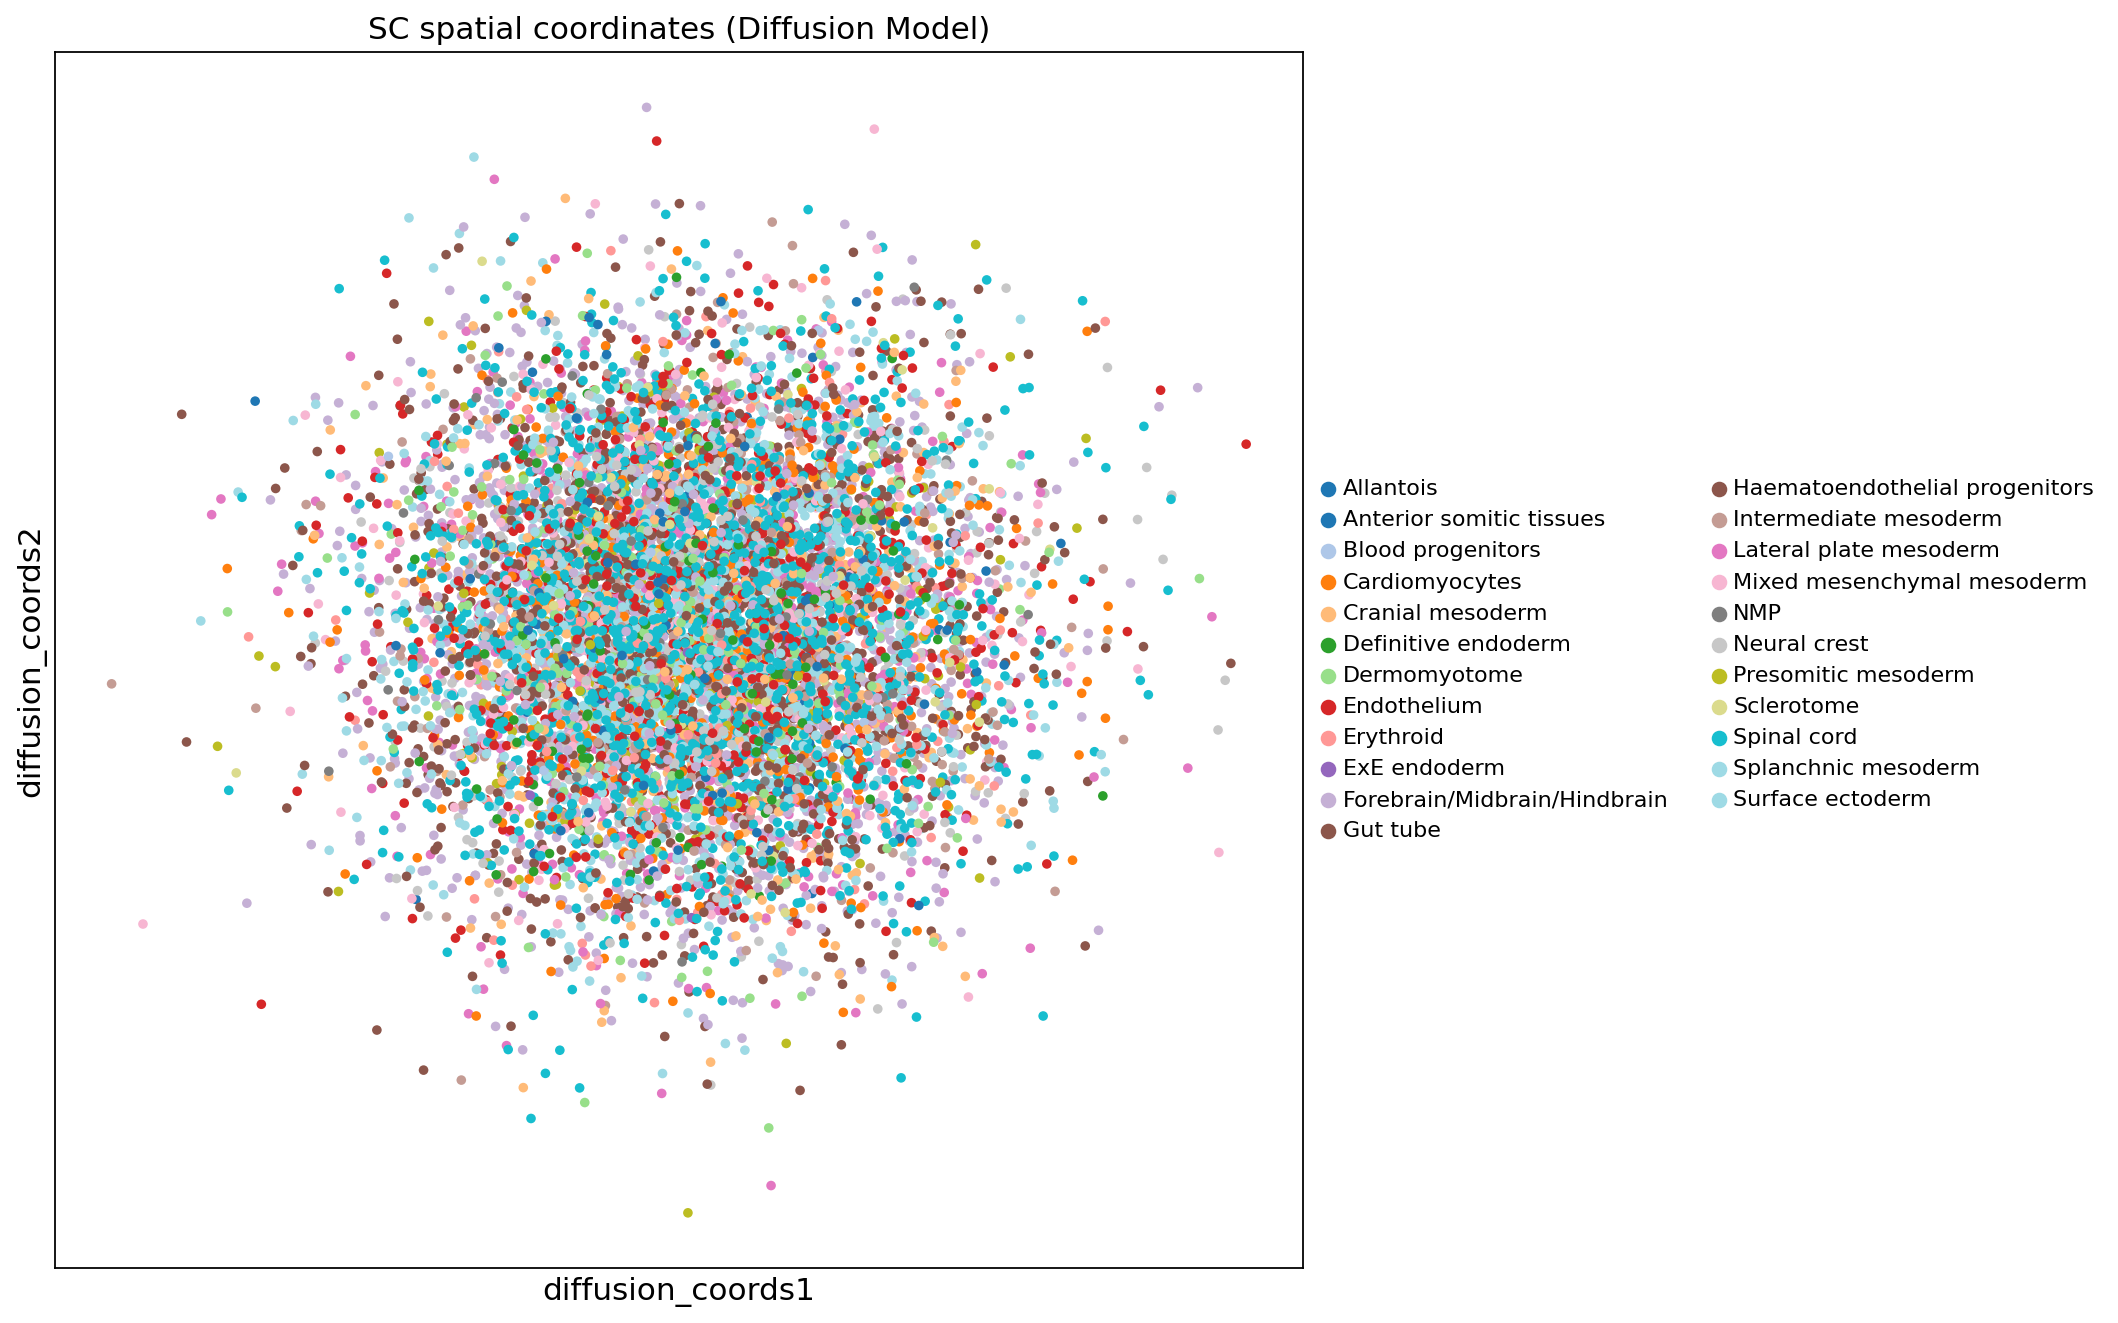

In [43]:
# sc_coords = diffusion.sample_sc_coordinates(timesteps=1000, lambda_structure=2.0)

adata.obsm['diffusion_coords'] = sc_coords.cpu().numpy()
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.set_figure_params(figsize=(10, 10))


#plot using scanypy's spatial plotting function with cell types as colors
sc.pl.embedding(adata, basis='diffusion_coords', color = 'celltype_mapped_refined',
                size=75, title='SC spatial coordinates (Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10)

In [ ]:
# After loading your data
if isinstance(Y_st, torch.Tensor):
    Y_st = Y_st.cpu().numpy()
if isinstance(X_st, torch.Tensor):
    X_st = X_st.cpu().numpy()
if isinstance(X_sc, torch.Tensor):
    X_sc = X_sc.cpu().numpy()
if isinstance(D_induced, torch.Tensor):
    D_induced = D_induced.cpu().numpy()

# Run the analysis
results = run_gnn_analysis(X_sc, D_induced)